#  Analyze Dog Data 


### import needed libraries

In [1]:
import requests
import os
import json
import time
import pandas as pd
import numpy as npp
import tweepy
import matplotlib.pyplot as plt

##  Gather 
### Existing files or urls :

In [2]:
archive = pd.read_csv('twitter-archive-enhanced.csv') #already gathered

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
content = response.content
prediction_folder = 'prediction_folder'
predictions_file_name = url.split('/')[-1]

In [4]:
if not os.path.exists(prediction_folder):
    os.makedirs(prediction_folder)

with open(os.path.join(prediction_folder,predictions_file_name),mode='wb') as file:
    file.write(response.content)

image_predictions = pd.read_csv(predictions_file_name,sep='\t')

#### Create an API object  to gather Twitter data.

In [6]:
consumer_key = '26tgFswcrskTs4XPdie0XlRnP'
consumer_secret = '70l0vuduT02mm6IswK75IMy0paCtwAioTxndMPlqARQbWKXHAf'
access_token = '1550344364-BHHQZTo98ixy6bUVorDi6KWtUonGrnnxDw60zfE'
access_secret = 'ivWV2ePqrQ6WzvsEdWb3qz1OistiSNBEVOdhovU4AiU39'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [7]:
user = api.get_user('dog_rates')
user_id = user.id
# Using the tweet IDs in the WeRateDogs Twitter archive
tweet_ids = archive.tweet_id
last_tweet_id = user.status.id
len(tweet_ids)

2356

#### Write JSON data 
Tweets are in json format, will query each tweet ID and  write its JSON data to `tweet_json.txt` file, with each tweet's JSON data on its own line.
<br> 20-30 minutes of running time is expected, to query all of the tweet IDs in archive

In [8]:
tweets = []    
n_crashed = 0
n_worked = 0

In [9]:
with open('tweet_json.txt', 'w', encoding='utf-8') as file:
    initial_time = time.time()
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            n_worked+=1
            json_content = tweet._json
            json.dump(json_content, file)
            file.write('\n')
        except:
            n_crashed+=1
final_time = time.time()

Rate limit reached. Sleeping for: 394
Rate limit reached. Sleeping for: 396


In [12]:
print("%s %d %s" % ('Time of runing  the code above :', (final_time-initial_time)/60,'Minutes'))
print("%s %d" % ('Number of tweets that are worked :', n_worked))
print("%s %d" % ('Number of tweets that are not worked :', n_crashed)) 
#why more than 2356? maby enter both try & except? 
#or counted retweets as well and mistakes or duplicates?

Time of runing  the code above : 35 Minutes
Number of tweets that are worked : 2331
Number of tweets that are not worked : 25


#### Read JSON data  
Will read **id, txt, retweets, and likes** as basics<br>
Will try to read **names, images, urls and ratings.** 

In [13]:
with_media = 0
with_url = 0
find_digit =0
data_missing =0
with open('tweet_json.txt', 'r',encoding='utf-8') as file:
    for single_line in file:
        
        tweet = json.loads(single_line)
        entities =  tweet['entities']
        
        d = { 'tweet_id': tweet['id'],
                        'text': tweet['full_text'],
                        'retweets': tweet['retweet_count'],
                        'likes': tweet['favorite_count']
                       }
        try:
                d['nemae'] = tweet['full_text'].split('.')[0].split(' ')[2]
        
        
        except:
                data_missing+=1
        
        try:
      
                d['image'] = entities['media'][0]['media_url_https']
                with_media+=1
     
        except:
                data_missing+=1    
        
        
        try:

                d['url']= entities['media'][0]['expanded_url']
                with_url+=1
        
        except:
                data_missing+=1
                
        try:
               
                x = tweet['full_text'].split('/')
                d['rating/10']= x[0][-2:]
                #d['second']= x[1][0:2] #always 10
                find_digit+=1
                
                
        except:
                data_missing+=1      
            
        tweets.append(d)

In [14]:
print( with_media ,' tweets with images')
print( with_url ,' tweets with urls')
print( data_missing ,' missing data')
print( find_digit ,' found ratings')

2059  tweets with images
2059  tweets with urls
777  missing data
2331  found ratings


In [15]:
dog_data = pd.DataFrame(tweets,columns=['tweet_id','image','url','text','name','rating/10','retweets','likes'])
dog_data.to_csv('data_collected.csv')

In [16]:
user.statuses_count 

13096

## <font color='purple'> Assess </font>

In this section I will assess both `image_predictions` and `archive`

In [17]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [19]:
all_columns = pd.Series(list(archive) + list(image_predictions))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

In [20]:
list(archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [21]:
archive[archive['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [22]:
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
559,803276597545603072,NaN,NaN,2016-11-28 16:37:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winston. His selfie game is legendary....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/803276597...,11,10,Winston,None,None,None,None
456,818259473185828864,NaN,NaN,2017-01-09 00:53:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Florence. He saw the same snap you sen...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818259473...,12,10,Florence,None,None,None,None
1713,680473011644985345,NaN,NaN,2015-12-25 19:39:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hector. He thinks he's a hammer. Silly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680473011...,10,10,Hector,None,None,pupper,None
405,823939628516474880,NaN,NaN,2017-01-24 17:04:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cash. He's officially given pup on tod...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/823939628...,12,10,Cash,None,None,None,None
1048,743253157753532416,NaN,NaN,2016-06-16 01:25:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,None,None,None,puppo


In [23]:
archive.name.value_counts()
# wrong extracted (a) nemes.

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Beckham      1
Cheesy       1
Bert         1
Kenzie       1
Ulysses      1
Name: name, Length: 957, dtype: int64

In [24]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [25]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [26]:
archive[archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [27]:
image_predictions[image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [28]:
sum(image_predictions.duplicated())

0

In [29]:
sum(archive.duplicated())

0

In [30]:
sum(archive.doggo.isnull()) # shoud have nulls None

0

In [31]:
sum(archive.floofer.isnull())

0

In [32]:
sum(archive.pupper.isnull())

0

In [33]:
sum(archive.puppo.isnull())

0

In [34]:
archive[archive.retweeted_status_id.isnull()==False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [35]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [36]:
image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [37]:
image_predictions.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [38]:
image_predictions.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [39]:
archive.timestamp.describe()

count                          2356
unique                         2356
top       2016-07-22 00:43:32 +0000
freq                              1
Name: timestamp, dtype: object

In [40]:
len(archive[archive.retweeted_status_id.isnull() == False])

181

In [41]:
list(archive[archive['expanded_urls'].isnull()]['source'])[6]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [42]:
sum(archive.duplicated())

0

In [43]:
max_rated = archive.rating_numerator.max()
high_rated_dog_data = archive[archive['rating_numerator']==max_rated]
high_rated_dog_data

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [44]:
low_rated = archive.rating_numerator.min()
low_rated_dog_data = archive[archive['rating_numerator']==low_rated]
low_rated_dog_data['expanded_urls'] #seems irrelevant, drop them

315     https://twitter.com/dog_rates/status/835152434...
1016    https://twitter.com/dog_rates/status/746906459...
Name: expanded_urls, dtype: object

In [45]:
high_rated_image = image_predictions[image_predictions['tweet_id']==749981277374128128].jpg_url
# high_rated_image = str(high_rated_image)
# high_rated_image = high_rated_image[len('1270'):].strip()
high_rated_image

1270    https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg
Name: jpg_url, dtype: object

In [46]:
import urllib

urllib.request.urlretrieve(' https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg', "high_rated_image.jpg")

('high_rated_image.jpg', <http.client.HTTPMessage at 0x7f9b6c0e3eb0>)

In [139]:
archive_clean_merged['rating_denominator'].value_counts() ##possible issue

10     1967
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [145]:
archive_clean_merged['rating_numerator'].value_counts()

12       448
10       418
11       396
13       257
9        151
8         95
7         52
14        35
6         32
5         32
3         19
4         16
2          9
1          5
121        1
24         1
80         1
45         1
88         1
99         1
144        1
84         1
11.26      1
44         1
50         1
13.5       1
143        1
60         1
11.27      1
1776       1
9.75       1
420        1
165        1
204        1
Name: rating_numerator, dtype: int64

In [146]:
archive_clean_merged['rating_numerator'].max()

'99'


### <font color='purple'> Tidiness issues</font>

- doggo, floofer, pupper, puppo are in several columns!
- Three data frames insted of one.

### <font color='purple'> Quality issues</font>

**General**
- Doggo, Floofer, Pupper and Puppo don't have nulls & have strings "none"
- Some data are not dog ratings 
- Some data are retweets.
- Duplicates
- Nedds number of retweets and likes columns
- Some rows with multiple dog stages
- For dog ratings, there are some observations with decimal ratings

**Data Types:**
- doggo, floofer, pupper, puppo are strings rather than categorial types 
: [id] is integer rather than string , timestamp is object!
- retweeted_status_id and retweeted_status_user_id are folat rather than int

**Undescreptive Names:**
- retweeted_status_id, retweeted_status_user_id  and retweeted_status_timestamp 

-  p1-p3 (in predictions data)

**Completeness:**
- missing values of expanded_urls
- missing values of [retweeted_status_timestamp, retweeted_status_user_id, retweeted_status_id,in_reply_to_status_id, in_reply_to_user_id ]
#- think of adding dog_data columns... like retweets and likes

# <font color='purple'> Clean </font>
-  The result was a very high quality and tidy master pandas DataFrames. The issues that satisfy the Project Motivation will be cleaned.

In [47]:
archive_copy = archive.copy()
predictions_copy = image_predictions.copy()

#### Define #1 completeness issues

##### (1) for the unrelated tweets(retweets and replays)

**Remove rows** where retweeted_status_timestamp, retweeted_status_user_id and retweeted_status_id columns contains values (not nulls). and then **drop these columns**.

##### (2) For teh expanded_urls:

The url alwayse = https://twitter.com/dog_rates/status + the id of the tweet
<br>will change all (archive_copy[archive_copy['expanded_urls'].isnull()==False])
<br>**Change the archive_copy['expanded_urls']** to be = 'https://twitter.com/dog_rates/status/' + archive_copy['tweet_id']





#### Code

In [48]:
archive_copy = archive_copy[archive_copy.retweeted_status_id.isnull()]
archive_copy.drop('retweeted_status_id',axis=1,inplace=True)
archive_copy.drop('retweeted_status_user_id',axis=1,inplace=True)
archive_copy.drop('retweeted_status_timestamp',axis=1,inplace=True)
archive_copy.drop('in_reply_to_status_id',axis=1,inplace=True)
archive_copy.drop('in_reply_to_user_id',axis=1,inplace=True)

In [49]:
archive_copy.reset_index = True

In [51]:
str1 = 'https://twitter.com/dog_rates/status/'
for i in range (2175):
#     print(i)
    if i ==19: # will reset indexes
        break;
    tweet_id = archive_copy['tweet_id'][i]
    archive_copy['expanded_urls'] = str1 + str(tweet_id)
    
    print(archive_copy['expanded_urls'][i])

https://twitter.com/dog_rates/status/892420643555336193
https://twitter.com/dog_rates/status/892177421306343426
https://twitter.com/dog_rates/status/891815181378084864
https://twitter.com/dog_rates/status/891689557279858688
https://twitter.com/dog_rates/status/891327558926688256
https://twitter.com/dog_rates/status/891087950875897856
https://twitter.com/dog_rates/status/890971913173991426
https://twitter.com/dog_rates/status/890729181411237888
https://twitter.com/dog_rates/status/890609185150312448
https://twitter.com/dog_rates/status/890240255349198849
https://twitter.com/dog_rates/status/890006608113172480
https://twitter.com/dog_rates/status/889880896479866881
https://twitter.com/dog_rates/status/889665388333682689
https://twitter.com/dog_rates/status/889638837579907072
https://twitter.com/dog_rates/status/889531135344209921
https://twitter.com/dog_rates/status/889278841981685760
https://twitter.com/dog_rates/status/888917238123831296
https://twitter.com/dog_rates/status/88880498919

#### Test

In [52]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2175 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   doggo               2175 non-null   object
 9   floofer             2175 non-null   object
 10  pupper              2175 non-null   object
 11  puppo               2175 non-null   object
dtypes: int64(3), object(9)
memory usage: 300.9+ KB


#### Define2
**Undescreptive Names** <br>
- Change p1-p3 (in predictions data) to pred_1, pred_2, pred_3

#### Code

In [53]:
image_predictions.columns = ['tweet_id','jpg_url','img_num','pred_1','p1_conf','p1_dog','pred_2','p2_conf','p2_dog','pred_3','p3_conf','p3_dog']

#### Test

In [54]:
image_predictions.head()

,tweet_id,jpg_url,img_num,pred_1,p1_conf,p1_dog,pred_2,p2_conf,p2_dog,pred_3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Define3
- Add one column `dog_stage` with values : doggo, floofer, pupper and puppo 
- Change the rows with multiple dog stages to have only one stage

#### Code

In [63]:
# handle none
archive_copy.doggo.replace('None', '', inplace=True)
archive_copy.floofer.replace('None', '', inplace=True)
archive_copy.pupper.replace('None', '', inplace=True)
archive_copy.puppo.replace('None', '', inplace=True)

In [64]:
# merge into column
archive_copy['dog_stage'] = archive_copy.doggo + archive_copy.floofer + archive_copy.pupper + archive_copy.puppo

In [65]:
# handle multiple stages
archive_copy.loc[archive_copy.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archive_copy.loc[archive_copy.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
archive_copy.loc[archive_copy.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [66]:
# handle missing values
archive_copy.loc[archive_copy.dog_stage == '', 'dog_stage'] = npp.nan

#### Test

In [ ]:
archive_copy.stage.value_counts()

In [ ]:
archive_copy.info()

In [ ]:
image_predictions.info()

#### Define4
**Data Types:**
- Change doggo, floofer, pupper, puppo to categorial types 
- Change id to string 
- Change timestamp to date

#### Code

In [67]:
archive_copy['doggo'] = archive_copy['doggo'].astype('category') 
archive_copy['floofer'] = archive_copy['floofer'].astype('category')
archive_copy['pupper'] = archive_copy['pupper'].astype('category')
archive_copy['puppo'] = archive_copy['puppo'].astype('category')
archive_copy['tweet_id'] = archive_copy['tweet_id'].astype('str')
archive_copy['timestamp'] = archive_copy['timestamp'].astype('datetime64[ns]')

#### Test

In [68]:
archive_copy.dtypes

tweet_id                      object
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
doggo                       category
floofer                     category
pupper                      category
puppo                       category
dog_stage                     object
dtype: object

#### Define5
- Remove all duplicates
- Remove irrelevants

#### Code

In [69]:
sum(image_predictions['tweet_id'].duplicated())

0

In [70]:
len(archive_copy), sum(archive_copy['tweet_id'].duplicated())

(2175, 0)

In [71]:
archive_copy = archive_copy[archive_copy['tweet_id'].duplicated()==False]

In [72]:
archive_clean = archive_copy[archive_copy.duplicated()==False]
archive_clean = archive_clean[archive_clean['rating_numerator']!=0]

#### Test

In [73]:
archive_clean[archive_clean.duplicated()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage


In [74]:
archive_clean['rating_numerator'].min()

1

In [75]:
len(archive_clean), sum(archive_clean['tweet_id'].duplicated())

(2173, 0)

In [76]:
len(dog_data),sum(dog_data['tweet_id'].duplicated())

(2331, 0)

In [77]:
len(image_predictions),sum(image_predictions['tweet_id'].duplicated())

(2075, 0)

#### Define6
Merge dataframes together

#### code

In [87]:
dog_data['tweet_id']=dog_data['tweet_id'].astype(str)
image_predictions['tweet_id']=image_predictions['tweet_id'].astype(str)
archive_clean_merged = pd.merge(archive_clean,dog_data,on='tweet_id')
archive_clean_merged = pd.merge(archive_clean_merged,image_predictions,on='tweet_id')

In [88]:
archive_clean_merged.drop(['text_y','name_y','rating/10'],axis=1,inplace=True)
archive_clean_merged.drop(['doggo','floofer','pupper','puppo'],axis=1,inplace=True)

#### test

In [89]:
archive_clean_merged.columns

Index(['tweet_id', 'timestamp', 'source', 'text_x', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name_x', 'dog_stage',
       'image', 'url', 'retweets', 'likes', 'jpg_url', 'img_num', 'pred_1',
       'p1_conf', 'p1_dog', 'pred_2', 'p2_conf', 'p2_dog', 'pred_3', 'p3_conf',
       'p3_dog'],
      dtype='object')

#### Define 7
Extract the decimal ratings with regular expressions.

#### Code

In [104]:
#find rows with decimal points in rating 
archive_clean_merged[archive_clean_merged.text_x.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id','text_x', 'rating_numerator']]

/Users/tamimisu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text_x,rating_numerator
39,883482846933004288,This is Bella. She hopes her smile made you sm...,5
498,786709082849828864,"This is Logan, the Chow who lived. He solemnly...",75
547,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1366,680494726643068929,Here we have uncovered an entire battalion of ...,26


In [150]:
archive_clean_merged['rating_numerator'] = archive_clean_merged['text_x'].str.extract('(\d+\.*\d*\/\d+)', expand=False).str.split('/').str[0]

In [151]:
archive_clean_merged['rating_numerator'] = archive_clean_merged['rating_numerator'].astype('float')
archive_clean_merged['rating_denominator'] = archive_clean_merged['rating_denominator'].astype('float')

#### Test

In [152]:
archive_clean_merged['rating_numerator'].max()

1776.0

In [154]:
archive_clean_merged['rating_numerator'].value_counts().sort_index()

1.00         5
2.00         9
3.00        19
4.00        16
5.00        32
6.00        32
7.00        52
8.00        95
9.00       151
9.75         1
10.00      418
11.00      396
11.26        1
11.27        1
12.00      448
13.00      257
13.50        1
14.00       35
24.00        1
44.00        1
45.00        1
50.00        1
60.00        1
80.00        1
84.00        1
88.00        1
99.00        1
121.00       1
143.00       1
144.00       1
165.00       1
204.00       1
420.00       1
1776.00      1
Name: rating_numerator, dtype: int64

## Store 

In [114]:
archive_clean_merged.to_csv('twitter_archive_master.csv')
predictions_copy.to_csv('predictions_cleaned.csv')

#  Analyze and  Visualize 

In [115]:
def PlotFunc(data,title,x,y1,y2,xlabel,ylabel):
    fig, ax = plt.subplots()
    data.plot(ax = ax,x = x, y = y1,title=title)
    data.plot(ax = ax,x = x, y = y2, c='r',title=title)
    ax.set(xticks=[])
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    return 

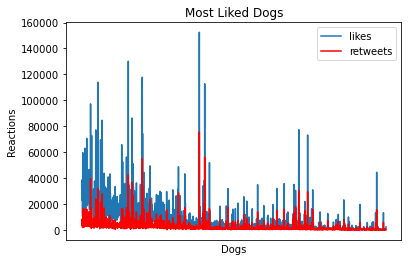

In [118]:
PlotFunc(archive_clean_merged,'Most Liked Dogs','tweet_id','likes','retweets','Dogs','Reactions')

In [119]:
max_likes = archive_clean_merged['likes'].max()
max_retweets = archive_clean_merged['retweets'].max()
max_likes,max_retweets

(152490, 75470)

In [120]:
liked_id = archive_clean_merged[archive_clean_merged['likes']==max_likes]['tweet_id']
liked_id

767    744234799360020481
Name: tweet_id, dtype: object

In [121]:
retweeted_id = archive_clean_merged[archive_clean_merged['retweets']==max_retweets]['tweet_id']
retweeted_id ##seems to be the same tweet

767    744234799360020481
Name: tweet_id, dtype: object

In [122]:
archive_clean_merged[archive_clean_merged['likes']==max_likes]

,tweet_id,timestamp,source,text_x,expanded_urls,rating_numerator,rating_denominator,name_x,dog_stage,image,...,img_num,pred_1,p1_conf,p1_dog,pred_2,p2_conf,p2_dog,pred_3,p3_conf,p3_dog
767,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/888554962...,13,10,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,...,1,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True


#### Common names of dogs

In [123]:
x = archive_clean_merged.name_x.value_counts()
x

None       544
a           55
Oliver      10
Cooper      10
Charlie     10
          ... 
Bilbo        1
Sailor       1
Beemo        1
Rose         1
Ulysses      1
Name: name_x, Length: 934, dtype: int64

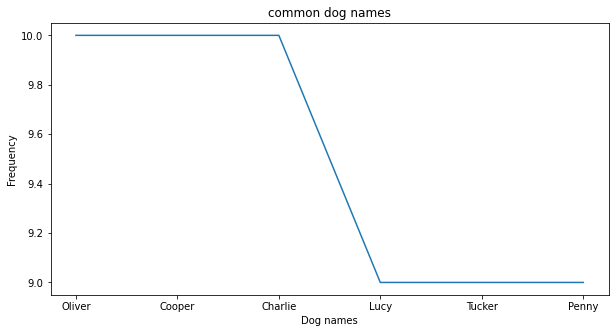

In [165]:
fig, ax = plt.subplots()

x[2:8].plot(figsize=(10,5), title='common dog names').set_xlabel("Dog names")
ax.set_ylabel("Frequency");

In [125]:
archive_clean_merged[archive_clean_merged['name_x']=='Cooper']['image']

101     https://pbs.twimg.com/media/DA23sCeVoAE3uF0.jpg
352     https://pbs.twimg.com/media/C09p5dJWIAE5qKL.jpg
393     https://pbs.twimg.com/media/CzaY5UdUoAAC91S.jpg
433     https://pbs.twimg.com/media/CxPPnCYWIAAo_ao.jpg
662     https://pbs.twimg.com/media/CoOTyXJXEAAtjs9.jpg
702     https://pbs.twimg.com/media/CmyPXNOW8AEtaJ-.jpg
994     https://pbs.twimg.com/media/CdO-6x5W8AENSBJ.jpg
1030    https://pbs.twimg.com/media/Cco8OmOXIAE0aCu.jpg
1087    https://pbs.twimg.com/media/CbYyCMbWEAAg7hR.jpg
1446    https://pbs.twimg.com/media/CWUZpydWcAAeipD.jpg
Name: image, dtype: object

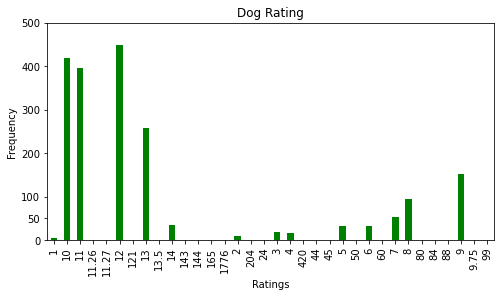

In [128]:
ratings = archive_clean_merged.rating_numerator.value_counts()
fig, ax = plt.subplots()
ax.set_xlabel("Ratings")
ax.set_ylabel("Frequency");
ratings.sort_index().plot(figsize=(8,4),kind = 'bar', title = 'Dog Rating',color = 'green')
ax.set_yticks([0, 50, 100, 200, 300, 400,500]);

In [161]:
rates = archive_clean_merged['rating_numerator']/archive_clean_merged['rating_denominator']
max_rated = rates.max()
high_rated = archive_clean_merged[archive_clean_merged['rating_numerator']/archive_clean_merged['rating_denominator']==max_rated]
high_rated

,tweet_id,timestamp,source,text_x,expanded_urls,rating_numerator,rating_denominator,name_x,dog_stage,image,...,img_num,pred_1,p1_conf,p1_dog,pred_2,p2_conf,p2_dog,pred_3,p3_conf,p3_dog
719,749981277374128128,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/888554962...,1776.0,10.0,Atticus,NaN,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,...,1,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False
